In [15]:
import numpy as np 
import cv2 
import zipfile
import io
import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings
import zipfile
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from PIL import Image


In [2]:
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o_kRuP_Bk_Pa2xvo1ly63w/data.zip'


def normalize(image):
    """
        Normalize the image to be in range 0 to 1

        Args:
            image: The input image
        Returns:
            The normalized image
    """
    return np.array(image) / 255.0


def center_crop(img, output_size):
    """
        Crop the image from the center
        
        Args:
            img: The input image
            output_size: The size of the output image
        Returns:
            The cropped image
    """
    img = np.array(img)

    start_y = (img.shape[0] - output_size[0]) // 2
    start_x = (img.shape[1] - output_size[1]) // 2

    cropped_img = img[start_y:start_y + output_size[0], start_x:start_x + output_size[1]]
    return cropped_img


def shape_process(img, input_size):
    """
    Resize the image if its height is odd and pad it to match the input size.
    
    Args:
        img (numpy array): The input image.
        input_size (tuple): The desired size of the output image as a tuple (height, width).
        
    Returns:
        numpy array: The processed image with the specified input size.
    """
    if img.shape[0] % 2:
        img = cv2.resize(img, img.shape[0] // 2, interpolation=cv2.INTER_CUBIC)
    padd = int((input_size[0] - img.shape[0]) / 2)
    img = cv2.copyMakeBorder(img, padd, padd, padd, padd, cv2.BORDER_REFLECT_101)

    return img



In [3]:

# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)


In [11]:
with open("med.zip","wb") as f:
    f.write(response.content)

In [16]:
zip_file=zipfile.ZipFile(zip_file_bytes)
zip_file.extractall("data")

In [4]:


# Initialize lists to hold images and labels
test_images = []
train_labels = []
train_images = []

with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
    sorted_files = sorted(zip_ref.namelist())
    for file_name in sorted_files:
        if file_name.endswith('.tif'):
            with zip_ref.open(file_name) as file:
                img = Image.open(file).convert('L')  # Convert to grayscale
                img = np.array(img)
                if '/train/images/' in file_name:
                    train_images.append(normalize(shape_process(img, (572, 572))))
                elif '/train/labels/' in file_name:
                    cropped_img = center_crop(img, (388, 388))
                    normalized_img = normalize(cropped_img)
                    mask = (normalized_img > 0.5).astype(int)
                    train_labels.append(mask)
                elif '/test/' in file_name:
                    test_images.append(normalize(shape_process(img, (572, 572))))

    train_images = np.asarray(train_images, dtype=np.float32)
    # [N, H, W, C]
    train_images = train_images[:, :, :, np.newaxis]

    test_images = np.asarray(test_images, dtype=np.float32)
    test_images = test_images[:, :, :, np.newaxis]

    train_labels = np.asarray(train_labels, dtype=np.float32)
    train_labels = train_labels[:, :, :, np.newaxis]

In [5]:
print("Train data ",train_images.shape)
print("Test data ",test_images.shape)
print("Train labels ",train_labels.shape)

Train data  (30, 572, 572, 1)
Test data  (30, 572, 572, 1)
Train labels  (30, 388, 388, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

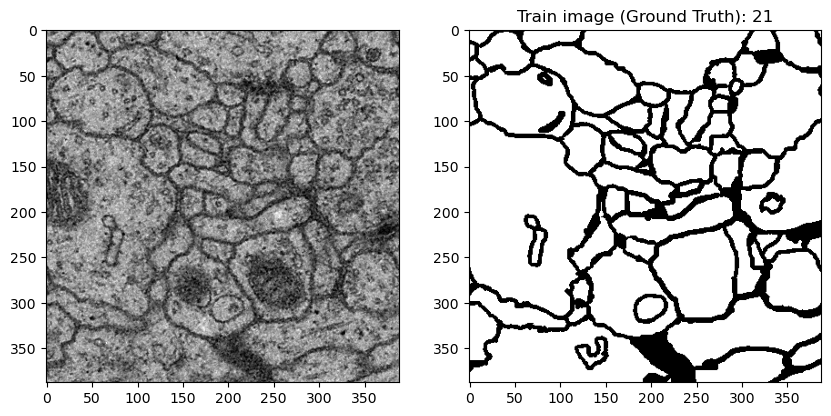

In [9]:
sample_image_indx=21
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_indx],(388,388))),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(np.squeeze(train_labels[sample_image_indx]),cmap="gray")
plt.title(f"Train image (Ground Truth): {sample_image_indx}")
plt.show